In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from utils import *

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 5

results = {}

prune_percentages = [70, 50, 30, 20, 15, 10, 8, 5, 3]

In [ ]:
# def create_prune_mask(model, prune_percentage=0.2):
#     mask = {}
#     for name, param in model.named_parameters():
#         if 'weight' in name:
#             threshold = torch.quantile(param.abs(), prune_percentage)
#             mask[name] = (param.abs() > threshold).float().to(device)
#     return mask

# def prune_model(model, mask):
#     """Aplica la máscara de pruning y registra hooks para mantenerla"""
#     with torch.no_grad():
#         for name, param in model.named_parameters():
#             if name in mask:
#                 param.data *= mask[name]
    
#     # Registrar hooks para mantener los pesos podados en cero
#     def maintain_mask_hook(grad, mask_tensor):
#         return grad * mask_tensor
    
#     for name, param in model.named_parameters():
#         if name in mask:
#             param.register_hook(lambda grad, m=mask[name]: maintain_mask_hook(grad, m))

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="../data/MNIST", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="../data/MNIST", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def run_experiment():
    global results
    for prune_percentage in prune_percentages:
        print(f"Pruneo al {prune_percentage}%")

        # Crear modelo y guardar estado inicial
        model = SimpleMLP().to(device)
        initial_state_dict = model.state_dict()

        # Entrenar modelo original
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_model(model, train_loader, criterion, optimizer, epochs)
        acc_original = evaluate_model(model, test_loader)

        # Pruneo del modelo
        prune_mask = create_prune_mask(model, prune_percentage / 100.0)
        model.load_state_dict(initial_state_dict)  # Reiniciar pesos iniciales
        prune_model(model, prune_mask)

        # Entrenar modelo pruned con máscara mantenida
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_model_with_mask(model, train_loader, criterion, optimizer, epochs, prune_mask)
        acc_pruned = evaluate_model(model, test_loader)

        # Guardar resultados
        results[prune_percentage] = {
            "accuracy_original": acc_original,
            "accuracy_pruned": acc_pruned
        }
        print(f"Accuracy original: {acc_original:.2%}, Accuracy pruned: {acc_pruned:.2%}")
        
        # Verificar que el porcentaje de pruning se mantuvo
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        zero_params = sum((p == 0).sum().item() for p in model.parameters() if p.requires_grad)
        actual_prune_percentage = (zero_params / total_params) * 100
        print(f"Porcentaje real de pruning: {actual_prune_percentage:.1f}%")

run_experiment()


Pruneo al 50%
Accuracy original: 97.65%, Accuracy pruned: 98.00%
Porcentaje real de pruning: 49.9%
Pruneo al 30%
Accuracy original: 98.08%, Accuracy pruned: 98.11%
Porcentaje real de pruning: 29.9%
Pruneo al 20%
Accuracy original: 97.66%, Accuracy pruned: 97.93%
Porcentaje real de pruning: 20.0%
Pruneo al 15%
Accuracy original: 97.63%, Accuracy pruned: 97.82%
Porcentaje real de pruning: 15.0%
Pruneo al 10%
Accuracy original: 97.70%, Accuracy pruned: 97.20%
Porcentaje real de pruning: 10.0%
Pruneo al 8%
Accuracy original: 97.83%, Accuracy pruned: 98.00%
Porcentaje real de pruning: 8.0%
Pruneo al 5%
Accuracy original: 98.02%, Accuracy pruned: 98.13%
Porcentaje real de pruning: 5.0%
Pruneo al 3%
Accuracy original: 97.16%, Accuracy pruned: 98.17%
Porcentaje real de pruning: 3.0%


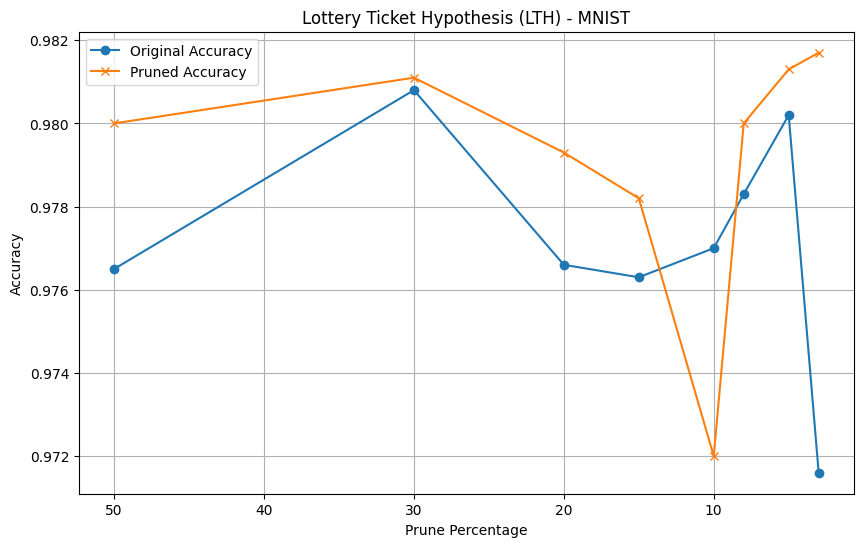

In [15]:
original_accuracies = [results[p]["accuracy_original"] for p in prune_percentages]
pruned_accuracies = [results[p]["accuracy_pruned"] for p in prune_percentages]

plt.figure(figsize=(10, 6))
plt.plot(prune_percentages, original_accuracies, label="Original Accuracy", marker="o")
plt.plot(prune_percentages, pruned_accuracies, label="Pruned Accuracy", marker="x")
plt.gca().invert_xaxis()  # Invertir eje X para visualizar mejor
plt.title("Lottery Ticket Hypothesis (LTH) - MNIST")
plt.xlabel("Prune Percentage")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()